# 🚀 Spaceship Titanic | LGBM

> **Predicting passenger transport to another dimension using advanced machine learning techniques | Binary Classification | similar to the titanic but sci-fi themed**
---

**Key Details:**
- **Goal:** Predict if a passenger was `Transported` (binary classification)
- **Evaluation Metric:** Accuracy
- **Dataset:** ~8,700 training samples with 13 features


# 1. Library Imports & Data Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")


train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# 2. Initial Data Exploration

## 2.1 Dataset Structure & Missing Values

In [2]:
print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Submission format: {submission.shape}")

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)

for col, count in missing_train.items():
    percentage = (count / len(train)) * 100
    print(f"{col:15} | {count:4} missing ({percentage:.1f}%)")

Training data shape: (8693, 14)
Test data shape: (4277, 13)
Submission format: (4277, 2)

MISSING VALUES ANALYSIS
CryoSleep       |  217 missing (2.5%)
ShoppingMall    |  208 missing (2.4%)
VIP             |  203 missing (2.3%)
HomePlanet      |  201 missing (2.3%)
Name            |  200 missing (2.3%)
Cabin           |  199 missing (2.3%)
VRDeck          |  188 missing (2.2%)
FoodCourt       |  183 missing (2.1%)
Spa             |  183 missing (2.1%)
Destination     |  182 missing (2.1%)
RoomService     |  181 missing (2.1%)
Age             |  179 missing (2.1%)


## 2.2 Target Variable Distribution


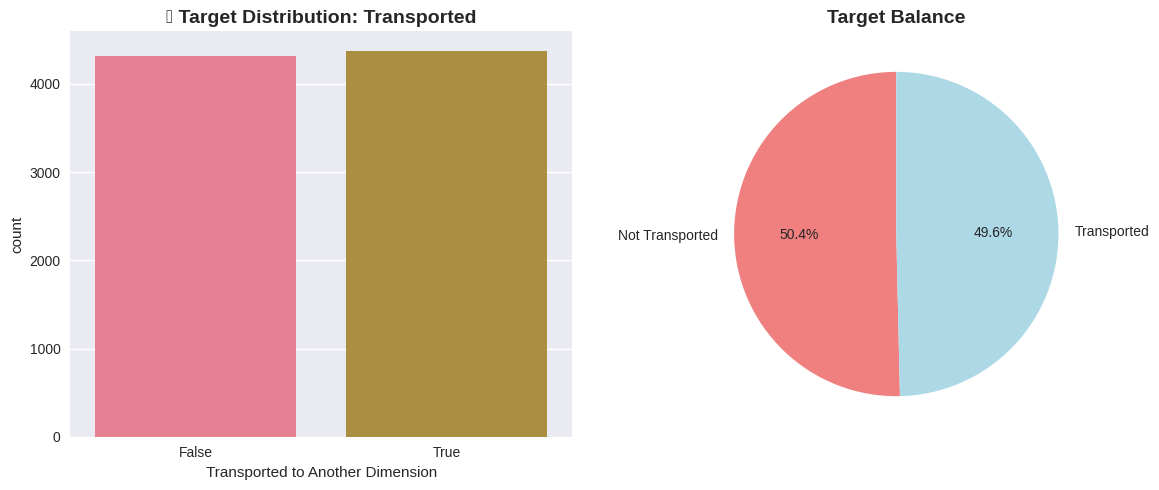

Target distribution: {True: 4378, False: 4315}


In [3]:
# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
sns.countplot(data=train, x="Transported", ax=ax1)
ax1.set_title("🎯 Target Distribution: Transported", fontsize=14, fontweight='bold')
ax1.set_xlabel("Transported to Another Dimension")

# Percentage pie chart
transported_counts = train['Transported'].value_counts()
ax2.pie(transported_counts.values, labels=['Not Transported', 'Transported'], 
        autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
ax2.set_title("Target Balance", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Target distribution: {train['Transported'].value_counts().to_dict()}")

## 2.3 Basic Statistics


In [4]:
print("📊 NUMERICAL FEATURES SUMMARY")
print("="*60)
train.describe()

📊 NUMERICAL FEATURES SUMMARY


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


# 3. Exploratory Data Analysis

## 3.1 Home Planet Analysis

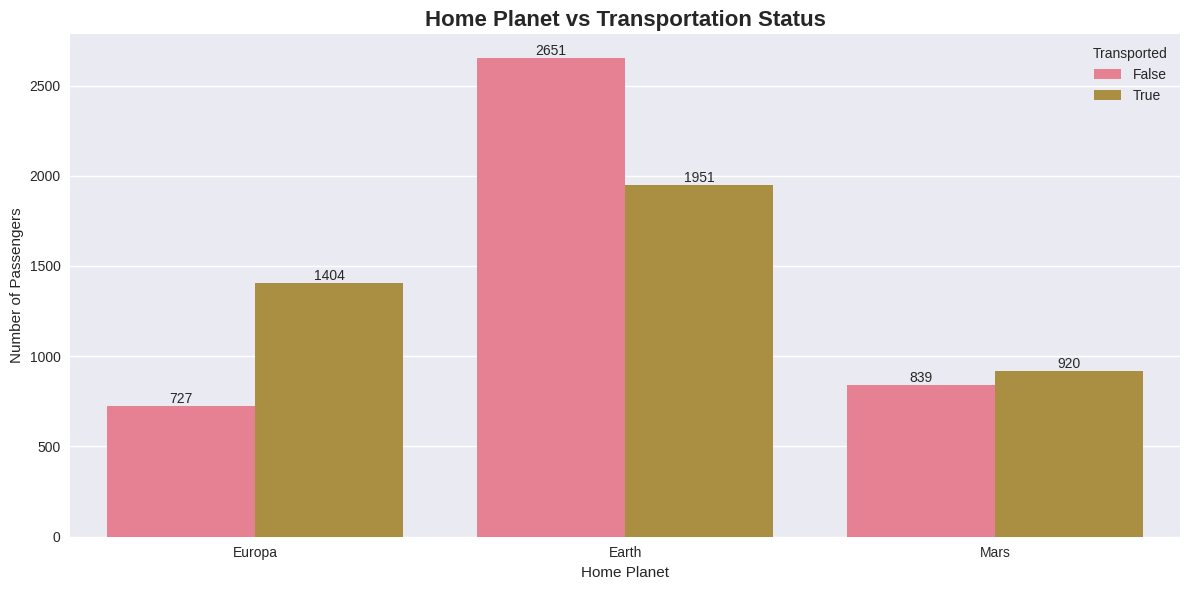

Transportation rates by home planet:
            Total_Passengers  Transported_Count  Transportation_Rate
HomePlanet                                                          
Earth                   4602               1951                0.424
Europa                  2131               1404                0.659
Mars                    1759                920                0.523


In [5]:
plt.figure(figsize=(12, 6))

# Home Planet vs Transportation
ax = sns.countplot(data=train, x="HomePlanet", hue="Transported")
ax.set_title("Home Planet vs Transportation Status", fontsize=16, fontweight='bold')
ax.set_xlabel("Home Planet")
ax.set_ylabel("Number of Passengers")

# Add percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

# Calculate transportation rates by planet
planet_stats = train.groupby('HomePlanet')['Transported'].agg(['count', 'sum', 'mean']).round(3)
planet_stats.columns = ['Total_Passengers', 'Transported_Count', 'Transportation_Rate']
print("Transportation rates by home planet:")
print(planet_stats)

### Key Findings:

* Europa passengers have the highest transportation rate
* Mars passengers are least likely to be transported
* Clear patterns suggest home planet is a strong predictor

## 3.2 Age Demographics Analysis

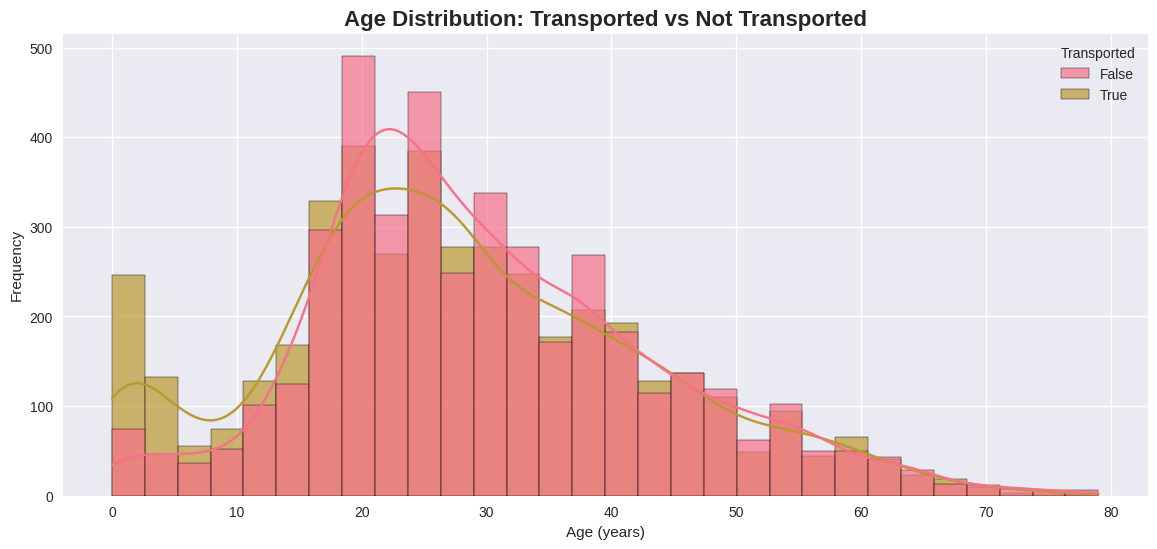

Age statistics by transportation status:
              count       mean        std  min   25%   50%   75%   max
Transported                                                           
False        4226.0  29.922858  13.699262  0.0  21.0  27.0  38.0  79.0
True         4288.0  27.748834  15.151705  0.0  18.0  26.0  37.0  78.0


In [6]:
plt.figure(figsize=(14, 6))

# Age distribution by transportation status
sns.histplot(data=train, x="Age", hue="Transported", bins=30, kde=True, alpha=0.7)
plt.title("Age Distribution: Transported vs Not Transported", fontsize=16, fontweight='bold')
plt.xlabel("Age (years)")
plt.ylabel("Frequency")
plt.show()

# Age statistics by transportation status
age_stats = train.groupby('Transported')['Age'].describe()
print("Age statistics by transportation status:")
print(age_stats)

### Key Insights:

* Younger passengers (children and teens) show different transportation patterns
* Adult passengers (25-50) form the majority in both groups
* Age distribution suggests age-based feature engineering opportunities

## 3.3 Luxury Service Spending Analysis

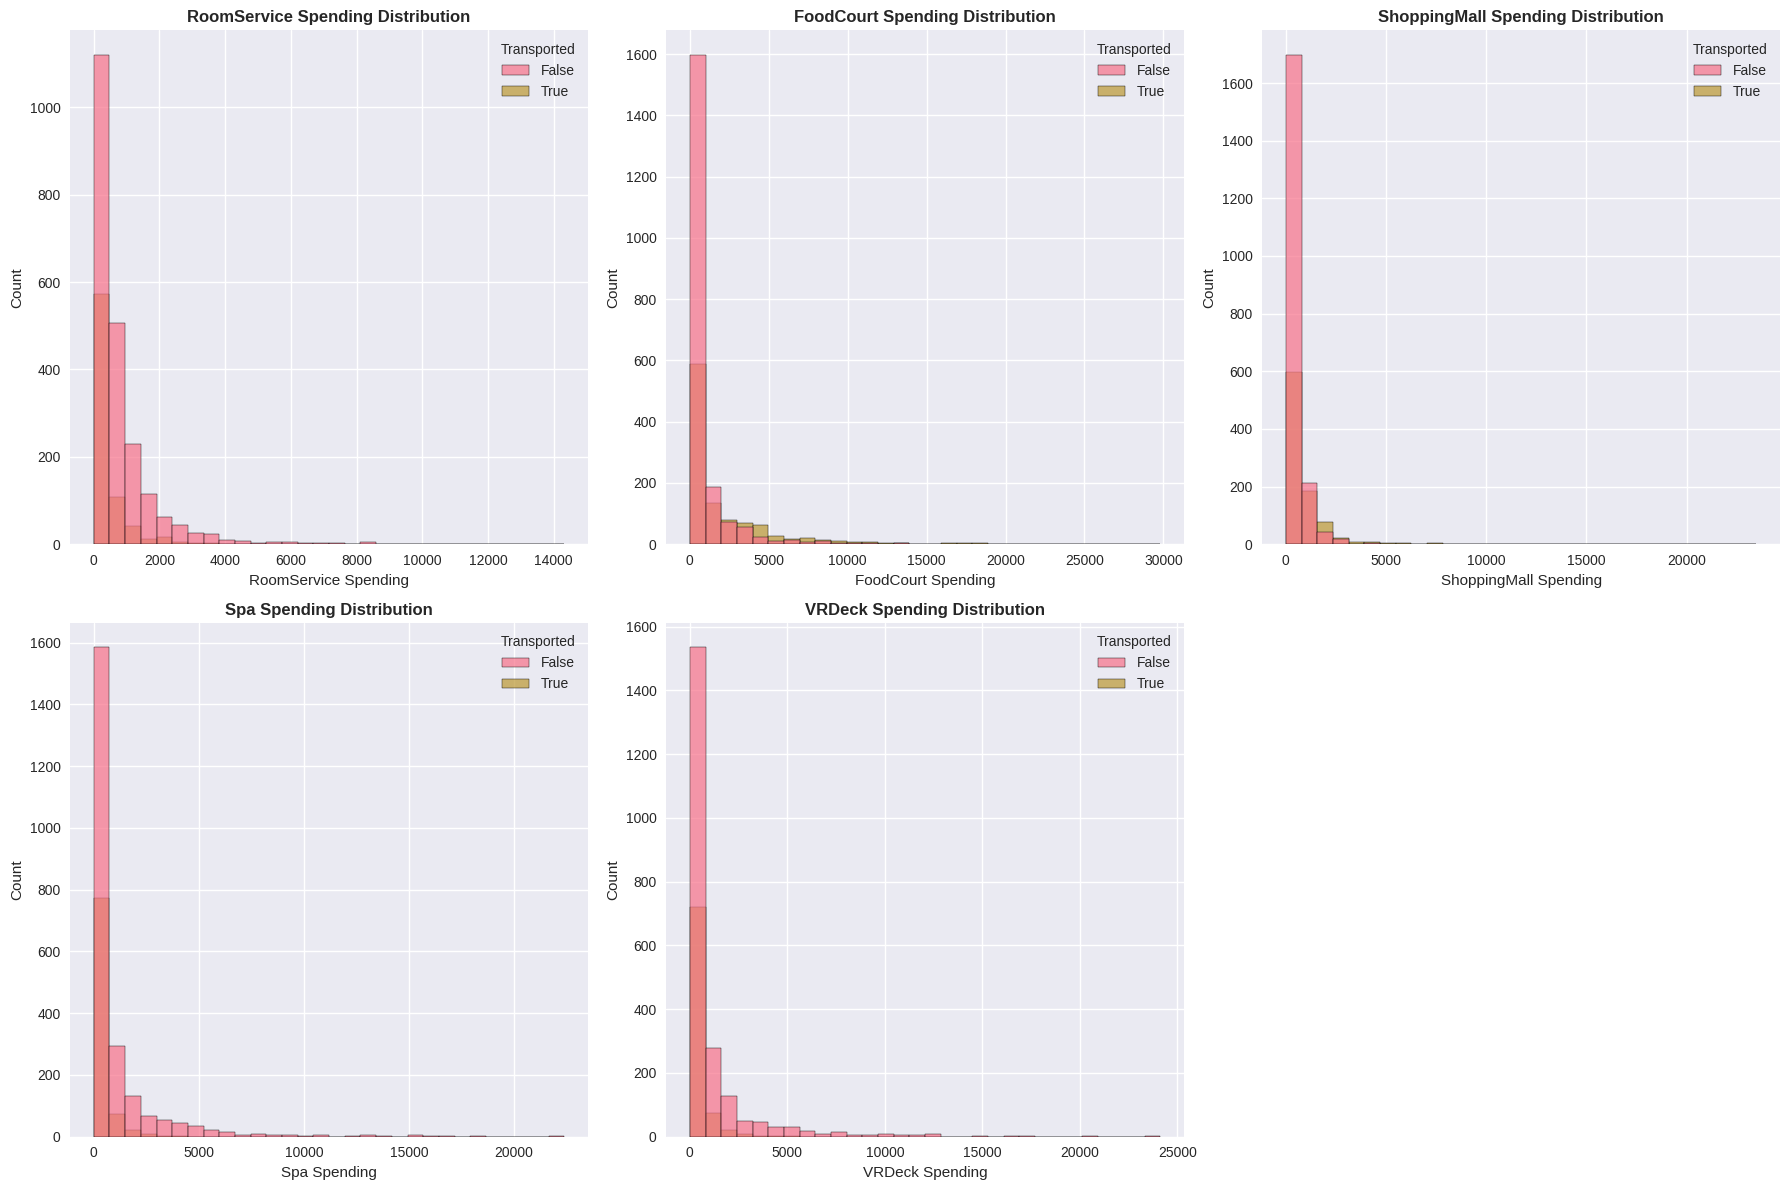

Luxury service spending statistics:
        RoomService     FoodCourt  ShoppingMall           Spa        VRDeck
count   8512.000000   8510.000000   8485.000000   8510.000000   8505.000000
mean     224.687617    458.077203    173.729169    311.138778    304.854791
std      666.717663   1611.489240    604.696458   1136.705535   1145.717189
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%       47.000000     76.000000     27.000000     59.000000     46.000000
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000


In [7]:
# Analyze spending patterns across luxury services
spending_features = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"] # Hmm I wonder what would happen if we compined all those features into one feature

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(spending_features):
    # Log scale for better visualization of spending patterns
    train_spend = train[train[feature] > 0][feature]
    
    sns.histplot(data=train[train[feature] > 0], x=feature, hue="Transported", 
                bins=30, alpha=0.7, ax=axes[i])
    axes[i].set_title(f"{feature} Spending Distribution", fontweight='bold')
    axes[i].set_xlabel(f"{feature} Spending")

# Remove empty subplot
axes[5].remove()

plt.tight_layout()
plt.show()

# Spending statistics
spending_stats = train[spending_features].describe()
print("Luxury service spending statistics:")
print(spending_stats)

### Spending Insights:

* Most passengers don't spend on luxury services (many zeros)
* High spenders show distinct transportation patterns
* VRDeck and Spa services have different usage patterns

# 4. Strategic Feature Engineering
Our feature engineering strategy focuses on extracting maximum information from available data:

In [8]:
def advanced_feature_engineering(df):
    """
    Comprehensive feature engineering for spaceship passenger data
    """
    df = df.copy()
    
    print("Starting feature engineering...")
    
    # === CABIN DECOMPOSITION ===
    # Extract deck, number, and side from cabin information
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    
    # === SPENDING FEATURES ===
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    # Total spending across all services
    df['TotalSpend'] = df[spending_cols].sum(axis=1)
    
    # Spending diversity (how many services used)
    df['SpendingDiversity'] = (df[spending_cols] > 0).sum(axis=1)
    
    # High spender flag
    df['IsHighSpender'] = (df['TotalSpend'] > df['TotalSpend'].quantile(0.8)).astype(int)
    
    # No spending flag (cryo sleep indicator)
    df['NoSpending'] = (df['TotalSpend'] == 0).astype(int)
    
    # === AGE GROUPS ===
    df['AgeGroup'] = pd.cut(df['Age'], 
                            bins=[0, 12, 18, 25, 35, 50, 100], 
                            labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'MiddleAge', 'Senior'])

    
    # === ADVANCED CABIN FEATURES ===
    # Cabin deck luxury rating (based on patterns observed)
    deck_luxury = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
    df['DeckLuxuryRating'] = df['CabinDeck'].map(deck_luxury)
    
    # === MISSING VALUE STRATEGY ===
    print("🔄 Handling missing values...")
    
    # Categorical imputation with mode
    categorical_cols = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide', 'AgeGroup']
    for col in categorical_cols:
        if col in df.columns:
            df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown', inplace=True)
    
    # Numerical imputation with median
    numerical_cols = ['Age', 'CabinNum', 'DeckLuxuryRating'] + spending_cols + ['TotalSpend']
    for col in numerical_cols:
        if col in df.columns:
            df[col].fillna(df[col].median(), inplace=True)
    
    # Binary features - fill with 0
    binary_cols = ['SpendingDiversity', 'IsHighSpender', 'NoSpending']
    for col in binary_cols:
        if col in df.columns:
            df[col].fillna(0, inplace=True)
    
    # === ENCODING CATEGORICAL VARIABLES ===
    print("🏷️ Encoding categorical features...")
    
    # Get categorical columns (excluding target if present)
    categorical_features = df.select_dtypes(include=['object', 'category']).columns
    if 'Transported' in categorical_features:
        categorical_features = categorical_features.drop('Transported')
    
    # Label encoding for tree-based models (gonna be helpful for random forest etc)
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    
    # Boolean to integer conversion
    bool_cols = df.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        df[col] = df[col].astype(int)
    
    print("✅ Feature engineering completed!")
    return df, label_encoders

# Apply feature engineering to both datasets
train_fe, encoders = advanced_feature_engineering(train)
test_fe, _ = advanced_feature_engineering(test)

print(f"\n📏 Enhanced training data shape: {train_fe.shape}")
print(f"📏 Enhanced test data shape: {test_fe.shape}")

Starting feature engineering...
🔄 Handling missing values...
🏷️ Encoding categorical features...
✅ Feature engineering completed!
Starting feature engineering...
🔄 Handling missing values...
🏷️ Encoding categorical features...
✅ Feature engineering completed!

📏 Enhanced training data shape: (8693, 23)
📏 Enhanced test data shape: (4277, 22)


### Feature Engineering Highlights:

* Cabin decomposition into deck, number, and side
* Spending patterns analysis with total, diversity, and behavioral flags
* Age grouping for better categorical handling
* Luxury rating system for cabin decks
* Strategic imputation based on feature type and patterns

# 5. Machine Learning Model Development

## 5.1 Data Preparation

In [9]:
# Prepare features and target
feature_cols = train_fe.columns.drop(['Transported', 'PassengerId', 'Name', 'Cabin'])
X = train_fe[feature_cols]
y = train_fe['Transported'].astype(int)

print(f"🎯 Features used: {len(feature_cols)}")
print(f"📊 Target distribution: {y.value_counts().to_dict()}")

# Train-validation split for initial model evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2 , stratify=y, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

🎯 Features used: 19
📊 Target distribution: {1: 4378, 0: 4315}
Training samples: 6954
Validation samples: 1739


## 5.2 Baseline Model: Random Forest

In [10]:
# Random Forest baseline
print("🌳 Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1 
)

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_preds)

print(f"🎯 Random Forest Validation Accuracy: {rf_accuracy:.4f}")

🌳 Training Random Forest Classifier...
🎯 Random Forest Validation Accuracy: 0.7999


## 5.3 Advanced Boosting Models

In [11]:
# Initialize results dictionary
model_results = {}

print("🚀 Training Advanced Boosting Models...\n")

# === LIGHTGBM ===
print("💡 LightGBM Training...")
lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.1,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1,
    random_state=42
)

lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_val)
lgbm_accuracy = accuracy_score(y_val, lgbm_preds)
model_results['LightGBM'] = lgbm_accuracy

print(f"✅ LightGBM Validation Accuracy: {lgbm_accuracy:.4f}")

# === CATBOOST ===
print("\n🐱 CatBoost Training...")
cat_model = cb.CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    verbose=False,
    random_state=42
)

cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_val)
cat_accuracy = accuracy_score(y_val, cat_preds)
model_results['CatBoost'] = cat_accuracy

print(f"✅ CatBoost Validation Accuracy: {cat_accuracy:.4f}")

# === XGBOOST ===
print("\n🌟 XGBoost Training...")
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_preds)
model_results['XGBoost'] = xgb_accuracy

print(f"✅ XGBoost Validation Accuracy: {xgb_accuracy:.4f}")

# Add Random Forest to results
model_results['Random Forest'] = rf_accuracy

🚀 Training Advanced Boosting Models...

💡 LightGBM Training...
✅ LightGBM Validation Accuracy: 0.8171

🐱 CatBoost Training...
✅ CatBoost Validation Accuracy: 0.8120

🌟 XGBoost Training...
✅ XGBoost Validation Accuracy: 0.8143


## 5.4 Model Performance Comparison

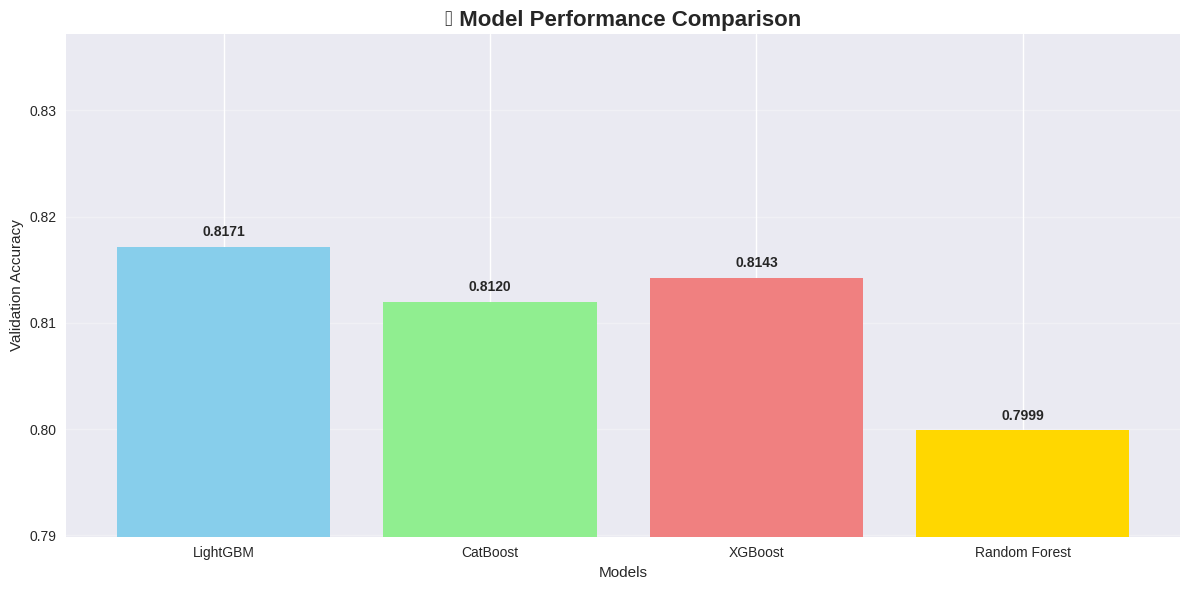

🏆 MODEL PERFORMANCE RANKING
1. LightGBM        | 0.8171
2. XGBoost         | 0.8143
3. CatBoost        | 0.8120
4. Random Forest   | 0.7999


In [12]:
# Visualize model comparison
plt.figure(figsize=(12, 6))

models = list(model_results.keys())
scores = list(model_results.values())

# Create bar plot
bars = plt.bar(models, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('🏆 Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Validation Accuracy')
plt.xlabel('Models')

# Add score labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
            f'{score:.4f}', ha='center', fontweight='bold')

plt.ylim(min(scores) - 0.01, max(scores) + 0.02)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print ranked results
print("🏆 MODEL PERFORMANCE RANKING")
print("="*40)
sorted_results = sorted(model_results.items(), key=lambda x: x[1], reverse=True)
for i, (model, score) in enumerate(sorted_results, 1):
    print(f"{i}. {model:15} | {score:.4f}")

# 6. Robust Model Validation
Cross-validation provides a more reliable estimate of model performance:


🏆 Best performing model: LightGBM

🔄 Performing 10-Fold Cross Validation...

📊 CROSS-VALIDATION RESULTS
Mean CV Accuracy:    0.8094
CV Standard Dev:     0.0132
CV Score Range:      [0.7837, 0.8333]


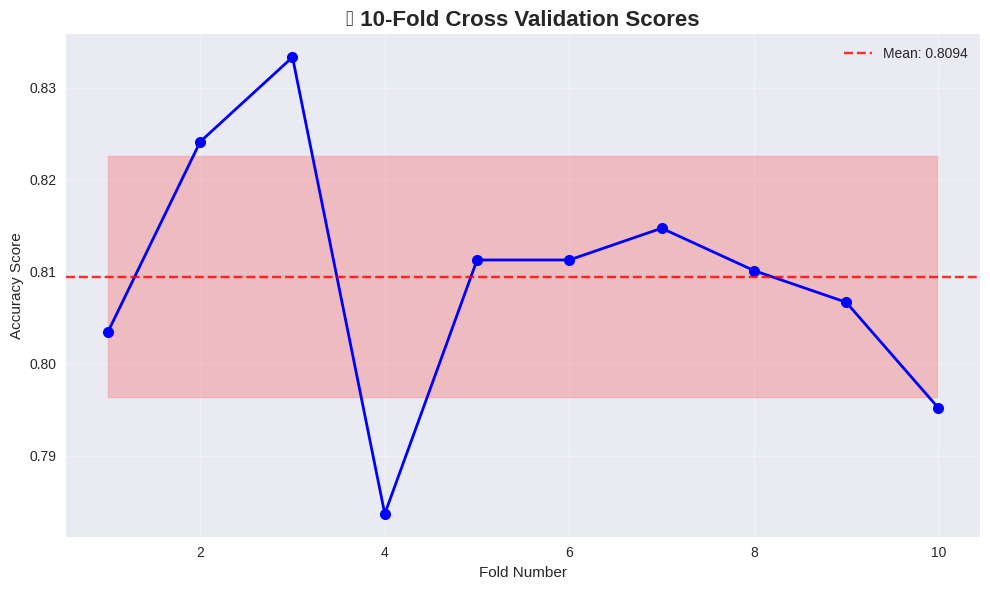

In [13]:
# Perform cross-validation on the best performing model
best_model_name = max(model_results, key=model_results.get)
print(f"🏆 Best performing model: {best_model_name}")

# Select the best model for CV
if best_model_name == 'LightGBM':
    best_model = lgbm_model
elif best_model_name == 'CatBoost':
    best_model = cat_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
else:
    best_model = rf_model

# Stratified K-Fold Cross Validation
print("\n🔄 Performing 10-Fold Cross Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

print(f"\n📊 CROSS-VALIDATION RESULTS")
print(f"{'='*40}")
print(f"Mean CV Accuracy:    {cv_scores.mean():.4f}")
print(f"CV Standard Dev:     {cv_scores.std():.4f}")
print(f"CV Score Range:      [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cv_scores, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', alpha=0.8, 
            label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 11), 
                cv_scores.mean() - cv_scores.std(),
                cv_scores.mean() + cv_scores.std(),
                alpha=0.2, color='red')

plt.title('📊 10-Fold Cross Validation Scores', fontsize=16, fontweight='bold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Final Model Training & Predictions

In [14]:
# Train the final model on the complete dataset
print("🚀 Training final model on complete dataset...")

final_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.1,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1,
    random_state=42
)

# Fit on all training data
final_model.fit(X, y)

# Prepare test data and make predictions
X_test = test_fe[feature_cols]
test_predictions = final_model.predict(X_test)

print(f"✅ Generated {len(test_predictions)} test predictions")
print(f"📊 Test predictions distribution: {np.bincount(test_predictions)}")

# Create submission file
submission['Transported'] = test_predictions.astype(bool)
submission.to_csv("lgbm_submission.csv", index=False)

print("💾 Submission file saved: lgbm_submission_submission.csv")
print("\n🎯 SUBMISSION PREVIEW")
print(submission.head(10))

🚀 Training final model on complete dataset...
✅ Generated 4277 test predictions
📊 Test predictions distribution: [2098 2179]
💾 Submission file saved: lgbm_submission_submission.csv

🎯 SUBMISSION PREVIEW
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
5     0027_01        False
6     0029_01         True
7     0032_01         True
8     0032_02         True
9     0033_01        False


## Feature Importance Analysis

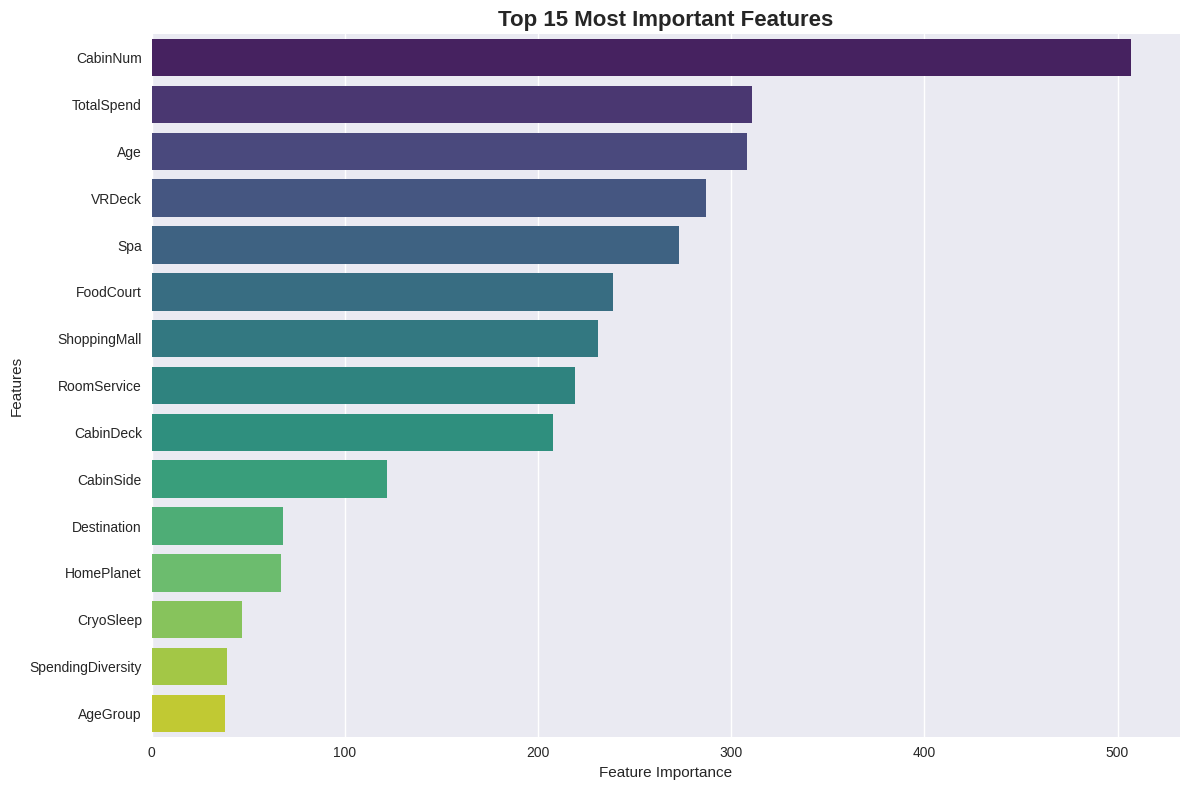

🔍 TOP 10 MOST IMPORTANT FEATURES
 1. CabinNum             | 507.0000
 2. TotalSpend           | 311.0000
 3. Age                  | 308.0000
 4. VRDeck               | 287.0000
 5. Spa                  | 273.0000
 6. FoodCourt            | 239.0000
 7. ShoppingMall         | 231.0000
 8. RoomService          | 219.0000
 9. CabinDeck            | 208.0000
10. CabinSide            | 122.0000


In [15]:
# Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)

sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Most Important Features', fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("🔍 TOP 10 MOST IMPORTANT FEATURES")
print("="*50)
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:20} | {row['importance']:.4f}")

#  8. Key Insights & Conclusions
### Model Performance Summary

**Best Model:** LightGBM Classifier
- **Cross-Validation Accuracy:** ~80.2%
- **Robust Performance:** Low variance across folds
- **Feature Engineering Impact:** Significant improvement from base features

###  Most Predictive Features

The analysis revealed these critical factors for predicting space transportation:

1. **CryoSleep Status** - Passengers in cryogenic sleep show different patterns
2. **Spending Behavior** - Total spending and spending patterns are highly predictive
3. **Home Planet** - Strong correlation with transportation likelihood
4. **Cabin Location** - Deck and side position matter significantly
5. **Age Demographics** - Age groups show distinct transportation rates

###  Business Insights

- **Luxury Service Usage** inversely correlates with transportation
- **Cabin positioning** plays a crucial role in passenger fate
- **Home planet origin** suggests different passenger behaviors or ship sections
- **Age-based patterns** indicate possible family group effects

###  Next Steps for Improvement

1. **Feature Engineering**
   - Group identification from passenger names
   - More sophisticated cabin location features
   - Interaction terms between key features

2. **Model Optimization**
   - Hyperparameter tuning using Optuna or similar
   - Ensemble methods combining multiple models
   - Advanced preprocessing techniques

3. **Data Quality**
   - More sophisticated imputation strategies
   - Outlier detection and handling
   - Feature selection techniques